# Caracterização do Perfil do Jato de gás

### Chamada de bibliotecas

Utilização de biblioteca PyAbel para caraccterização do feixe

In [450]:
%matplotlib nbagg
import abel
import scipy
import cmath
import numpy as np
from typing import Tuple
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.backend_bases import MouseButton
from mpl_point_clicker import clicker
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter
import mplcursors

from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

### Imagem Original do Interferômetro

In [451]:
#Imagens do interferograma
originalref = Image.open('imgref.bmp')
originalgas = Image.open('imggas.bmp')

phase_ref = np.asarray(originalref)
phase_gas = np.asarray(originalgas)

#Fatiar imagem com 3 canais
intref = phase_ref[:,:,0]
intgas = phase_gas[:,:,0]

<IPython.core.display.Javascript object>


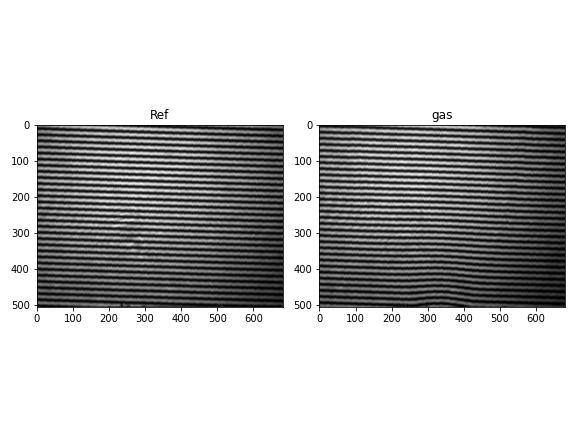

In [452]:
# Verificar imagens
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(intref, cmap='gray')
axs[1].imshow(intgas, cmap='gray')

axs[0].set_title('Ref')
axs[1].set_title('gas')

plt.tight_layout()
plt.show()

### Aplicar TF na imagem

In [453]:
#Calcular transformada de fourier das imagens
fftref = np.fft.fft2(intref)
fftgas = np.fft.fft2(intgas)

<IPython.core.display.Javascript object>


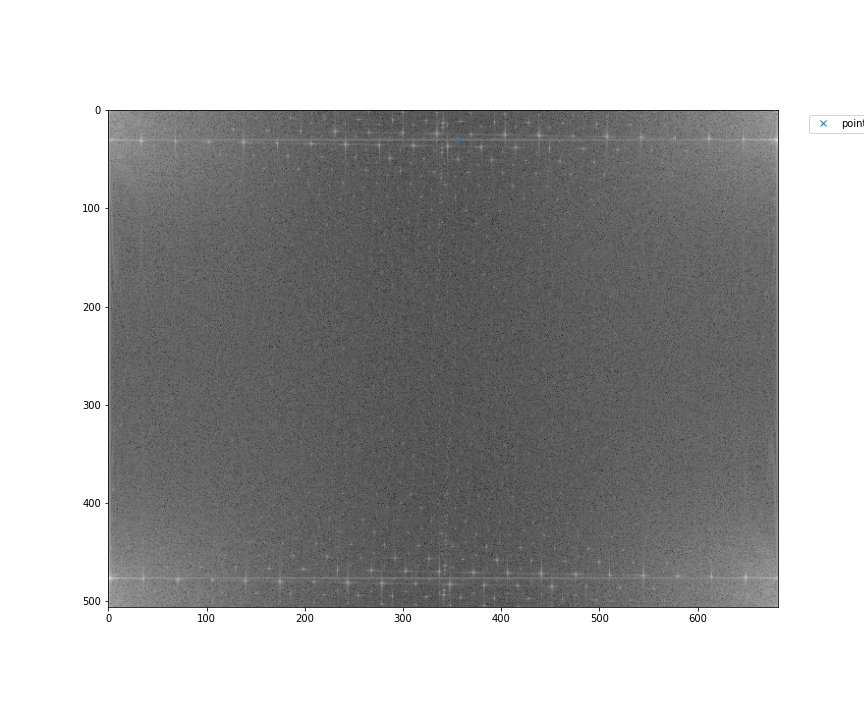

In [454]:
#Determinar pontos de referência para corte e rotação
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(np.log(np.abs(fftref)), cmap='gray')
klicker = clicker(ax, ['points'], markers=['x'])


def point_added_cb(position: Tuple[float, float], klass: str):
    x, y = position
    print(f"New point of class {klass} added at {x=}, {y=}")


def point_removed_cb(position: Tuple[float, float], klass: str, idx):
    x, y = position

    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(idx, 'th')
    print(
        f"The {idx}{suffix} point of class {klass} with position {x=:.2f}, {y=:.2f}  was removed"
    )

klicker.on_point_added(point_added_cb)
klicker.on_point_removed(point_removed_cb)

plt.show()

In [457]:
max_nlines, max_nrows = np.shape(fftgas)
#Pontos de referência do filtro

centerfilter = int((klicker.get_positions())['points'][0][1])
sigma = 8

print(centerfilter)
print(np.shape(fftgas))

29
(506, 682)


In [458]:
#Criando matrizes nulas
gfilter = np.zeros(np.shape(fftgas))

#filtro
#x = np.ones(np.shape(fftgas_filter[693:697][:])
gfilter[centerfilter-sigma:centerfilter+sigma][:] = np.ones(np.shape(fftgas[centerfilter-sigma:centerfilter+sigma][:]))

### Aplicar Filtro Gaussiano

In [459]:
gfilter[centerfilter-3*sigma:centerfilter+3*sigma][:] =\
    gaussian_filter(gfilter[centerfilter-3*sigma:centerfilter+3*sigma][:],sigma=8)

<IPython.core.display.Javascript object>


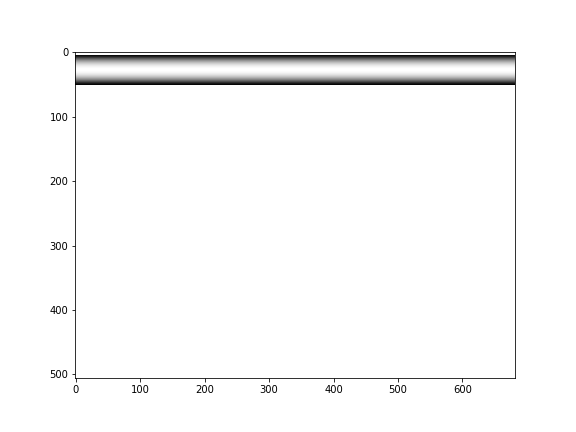

/tmp/ipykernel_10456/3083541519.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(gfilter)), cmap='gray')


In [460]:
plt.figure(figsize=(8,6))
plt.imshow(np.log(np.abs(gfilter)), cmap='gray')
plt.show()

### Transformada inversa da Imagem

In [461]:
#Calcullar a TF inversa
ifftref = np.fft.ifft2(gfilter*fftref)
ifftgas = np.fft.ifft2(gfilter*fftgas)

<IPython.core.display.Javascript object>


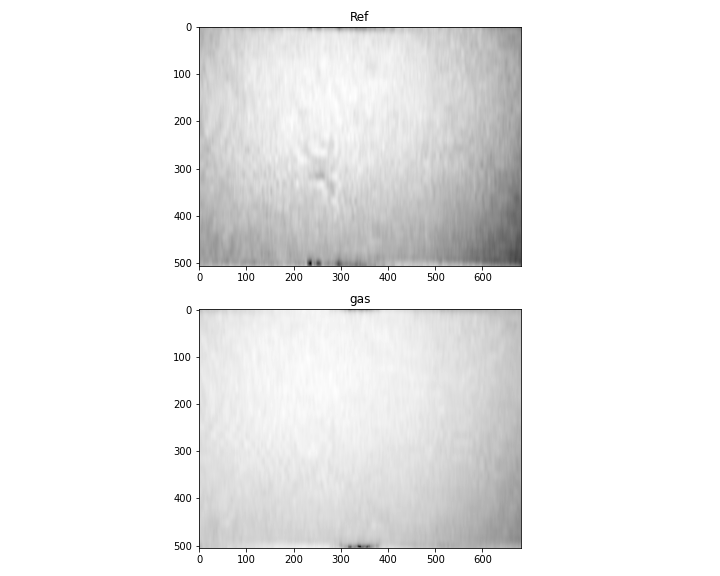

In [462]:
# Verificar imagens
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].imshow(np.log(np.abs(ifftref)), cmap='gray')
axs[1].imshow(np.log(np.abs(ifftgas)), cmap='gray')

axs[0].set_title('Ref')
axs[1].set_title('gas')

plt.tight_layout()
plt.show()

In [463]:
#Subtração das transformadas inversas e calculo do argumento
result = np.angle(ifftgas)-np.angle(ifftref)

In [464]:
baseline = abs(np.min(result))
print(baseline)

6.108728803499105


<IPython.core.display.Javascript object>


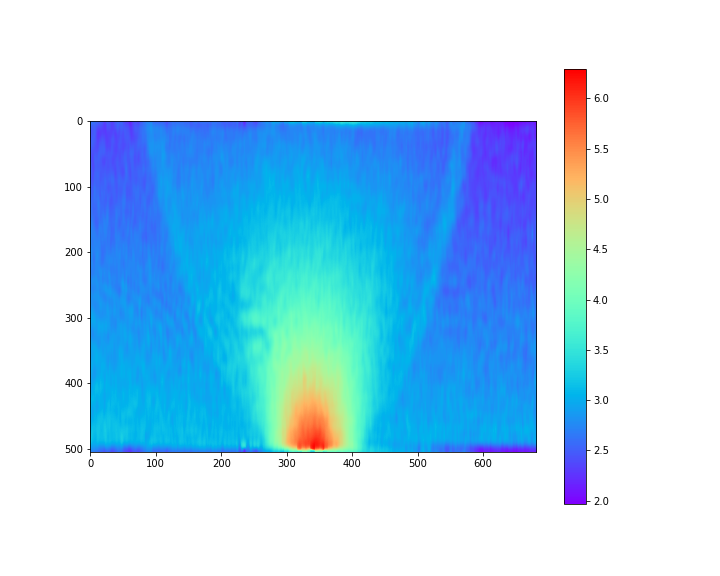

In [465]:
perfil = (unwrap_phase(result+baseline))#-np.ones(np.shape(result))*np.min(result))
perfil=perfil
plt.figure(figsize=(10,8))

mplcursors.cursor()
plt.tight_layout()
plt.imshow(perfil, cmap='rainbow')
plt.colorbar()

In [466]:
np.shape(perfil)

(506, 682)

In [467]:
cx,cy = np.where(perfil==perfil.max())
origin = (np.median(cx),np.median(cy))
print(origin)

(497.0, 342.0)


In [468]:
perfil_com = gaussian_filter(perfil,sigma = 10)#[:,int(cy-300):int(cy+301)],sigma = 8)

[[2.53029055 2.52945637 2.52780265 ... 2.17643529 2.17640565 2.17638718]
 [2.52955361 2.52872061 2.52706927 ... 2.17692936 2.17689762 2.17687809]
 [2.52809636 2.52726571 2.52561907 ... 2.17790614 2.17787029 2.17784871]
 ...
 [2.86855986 2.86808288 2.8671381  ... 2.49163266 2.49226775 2.49258809]
 [2.86507146 2.86458712 2.86362772 ... 2.48543391 2.48607574 2.48639947]
 [2.86331085 2.86282279 2.86185602 ... 2.48230419 2.48294938 2.48327481]]


In [469]:
inverse_abel = abel.Transform(perfil_com, symmetry_axis=0, direction='inverse',
                              method='three_point', verbose=True, angular_integration = True).transform

In [470]:
original_corr = perfil_com[:,int(cy-300):int(cy+301)]-np.min(perfil_com[:,int(cy-300):int(cy+301)])
abel_corr = inverse_abel[:,int(cy-300):int(cy+301)]-np.min(inverse_abel[:,int(cy-300):int(cy+301)])
print(np.shape(original_corr))

(506, 601)


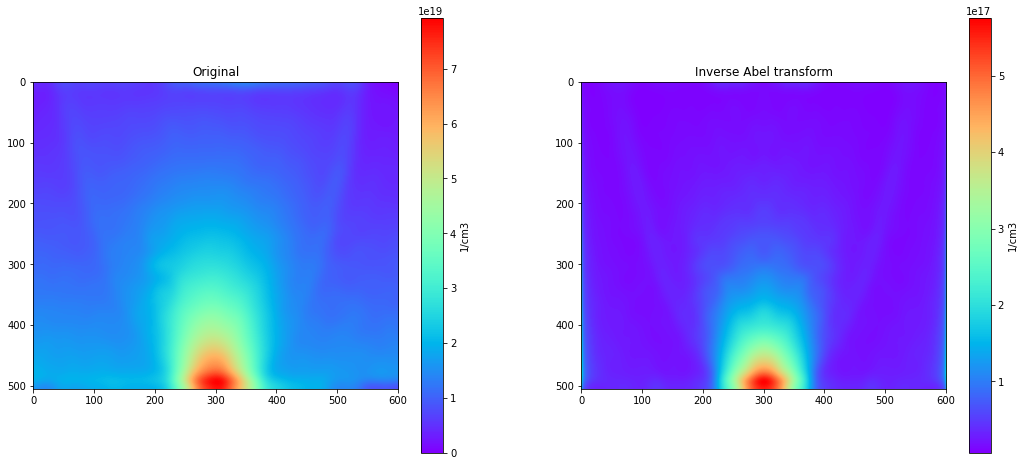

In [482]:
#definir comp. de bordas a partir do FWHM do ajuste de curvas gaussianas para cada linha da imagem
#Define the Gaussian function
%matplotlib inline
gas_dens =[]
nlines,nrows = np.shape(original_corr)
factor = 0.0002462923728813559

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

for i in range(0,nlines):
    x_fit = np.arange(0,nrows,1)
    y_fit = original_corr[i][:]
    x0_fit = np.argmax(original_corr[i][:])
    fit_parameters,_ = curve_fit(gauss,x_fit,y_fit)
    
    border_comp = fit_parameters[2]*factor#pixel pra cm
    #determinar o indice de refração    
    index_n = 1 + (y_fit*lambda0)/(2*np.pi*border_comp)
    
    #densidade do gas
    gas_dens.append((3/(4*np.pi*alpha_N2))*((index_n**2-1)/(index_n**2+2)))

gas_dens_abel = abel.Transform(np.asarray(gas_dens), symmetry_axis=0, direction='inverse', method='three_point', verbose=True, angular_integration = True).transform

fig,(ax0, ax1) = plt.subplots(1,2, figsize=(18, 8))

original_plot = ax0.imshow(gas_dens, cmap='rainbow')
abel_plot = ax1.imshow(gas_dens_abel, cmap='rainbow')
cb0 = fig.colorbar(original_plot, ax=ax0, label='1/cm3')
cb1 = fig.colorbar(abel_plot, ax=ax1, label='1/cm3')

ax0.set_title('Original')
ax1.set_title('Inverse Abel transform')

plt.show()

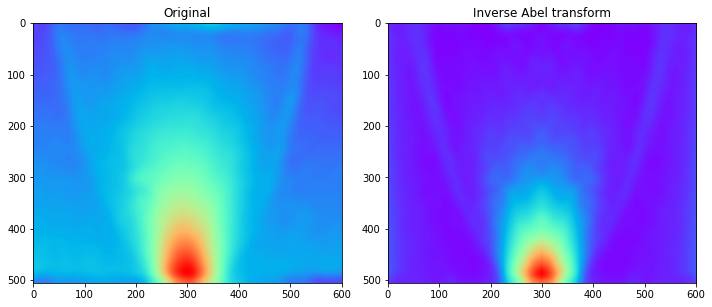

In [472]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(original_corr, cmap='rainbow')
axs[1].imshow(abel_corr, cmap='rainbow')

axs[0].set_title('Original')
axs[1].set_title('Inverse Abel transform')

plt.tight_layout()
plt.show()

In [473]:
%matplotlib inline

def perfilscan(i=500):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    y1 = abel_corr[i][:]#[100:nrows-100]
    y0 = original_corr[i][:]#[100:nrows-100]
    x = np.arange(0,nrows,1)#(100,nrows-100,1)
    
    #determinando comprimento da borda do jato a partir da gaussiana
    #x1_orig,x2_orig = np.where(y==0.05*perfil.max())
    
    axs[0].set_title('Original')
    axs[1].set_title('Inverse Abel transform')
    axs[0].plot(x,y0)
    axs[1].plot(x,y1,'red')
    
    plt.show()

interact(perfilscan,i=(0,nlines))

interactive(children=(IntSlider(value=500, description='i', max=506), Output()), _dom_classes=('widget-interac…

<function __main__.perfilscan(i=500)>

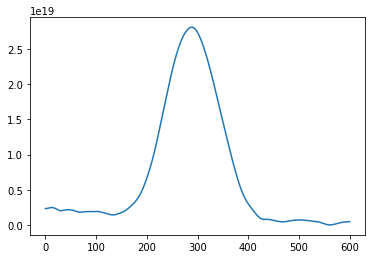

In [353]:
#determinar o indice de refração
lambda0 = 395e-7 #cm
alpha_N2 = 1.7e-24 #cm3

factor = 0.0002462923728813559
border_comp = 200*factor#pixel pra cm+2y1 = inverse_abel[500][int(cy-300):int(cy+301)]


index_n = 1 + (y0*lambda0)/(2*np.pi*border_comp)

dens = (3/(4*np.pi*alpha_N2))*((index_n**2-1)/(index_n**2+2))

plt.plot(dens)

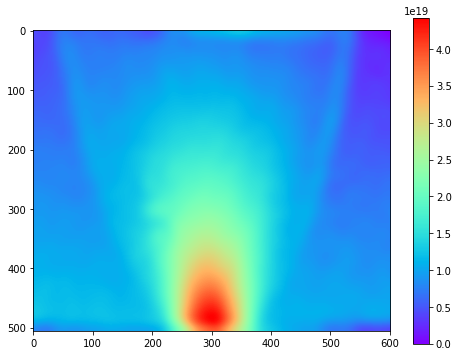

In [354]:
plt.figure(figsize=(8,6))
index_n2 = 1 + (original_corr*lambda0)/(2*np.pi*border_comp)

dens2 = (3/(4*np.pi*alpha_N2))*((index_n2**2-1)/(index_n2**2+2))

plt.imshow(dens2, cmap='rainbow')
plt.colorbar()